In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import matplotlib

In [2]:
warnings.simplefilter("ignore")

# Experimental data preparation

In [3]:
# read the efeatures and retained only the neurons selected during the preliminary quality checks
experiment_df = pd.read_csv('preprocessed_data_efeatures_selection.csv')

In [4]:
# reduce the attributes to the AP counts
experiment_df = experiment_df[['state',  'step current', 'stim dur', 'protocol', 
                               'AP_count', 'AP_count_before_stim', 'AP_count_after_stim']]

In [5]:
# rename columns
experiment_df.rename(columns={'stim dur':'duration', 'step current':'amplitude'}, inplace=True)

In [6]:
# rename state
experiment_df['state'].replace({'control':'normal'}, inplace=True)

In [7]:
# we are not interested 
# boundaries
experiment_df = pd.concat([
    experiment_df[(experiment_df['protocol'] == 'fi') & experiment_df['amplitude'].between(0, 300)],
    experiment_df[(experiment_df['protocol'] == 'rmih') & experiment_df['amplitude'].between(-200, -50)],
    experiment_df[(experiment_df['protocol'] == 'tburst') & (experiment_df['duration'] == 2000) & experiment_df['amplitude'].between(-300, -100)]
])

In [8]:
experiment_df.groupby(['protocol', 'duration', 'amplitude', 'state']).count()

AP_count  AP_count_before_stim  \
protocol duration amplitude state                                    
fi       2000.0    20.0     6ohda          7                     7   
                            normal         9                     9   
                   40.0     6ohda          7                     7   
                            normal         9                     9   
                   60.0     6ohda          7                     7   
                            normal         9                     9   
                   80.0     6ohda          7                     7   
                            normal         9                     9   
                   100.0    6ohda          7                     7   
                            normal         9                     9   
                   120.0    6ohda          7                     7   
                            normal         9                     9   
                   140.0    6ohda          7                     7   
                            normal         9                     9   
                   160.0    6ohda          7                     7   
                            normal         9                     9   
                   180.0    6ohda          7                     7   
                            normal         9                     9   
                   200.0    6ohda          7                     7   
                            normal         9                     9   
                   220.0    6ohda          7                     7   
                            normal         9                     9   
                   240.0    6ohda          7                     7   
                            normal         9                     9   
                   260.0    6ohda          6                     6   
                            normal         9                     9   
                   280.0    6ohda          4                     4   
                            normal         9                     9   
                   300.0    6ohda          3                     3   
                            normal         8                     8   
rmih     2000.0   -200.0    6ohda          0                     7   
                            normal         0                     8   
                  -150.0    6ohda          0                     6   
                            normal         0                     8   
                  -100.0    6ohda          0                     7   
                            normal         0                     8   
                  -50.0     6ohda          0                     6   
                            normal         0                     8   
tburst   2000.0   -300.0    6ohda          0                     5   
                            normal         0                     7   
                  -250.0    6ohda          0                     7   
                            normal         0                     7   
                  -200.0    6ohda          0                     7   
                            normal         0                     7   
                  -150.0    6ohda          0                     7   
                            normal         0                     7   
                  -100.0    6ohda          0                     6   
                            normal         0                     7   

                                    AP_count_after_stim  
protocol duration amplitude state                        
fi       2000.0    20.0     6ohda                     7  
                            normal                    9  
                   40.0     6ohda                     7  
                            normal                    9  
                   60.0     6ohda                     7  
                            normal                    9  
                   80.0     6ohda                     7  
             

<AxesSubplot:xlabel='amplitude', ylabel='AP_count'>

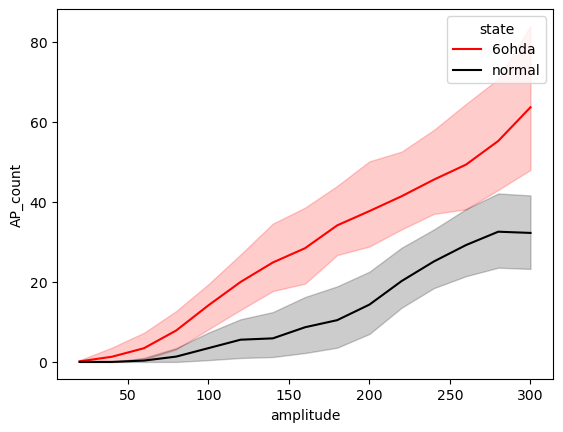

In [9]:
sns.lineplot(data=experiment_df[experiment_df['protocol'] == 'fi'], x='amplitude', y='AP_count', hue='state', palette=['red', 'black'])

<AxesSubplot:xlabel='amplitude', ylabel='AP_count_after_stim'>

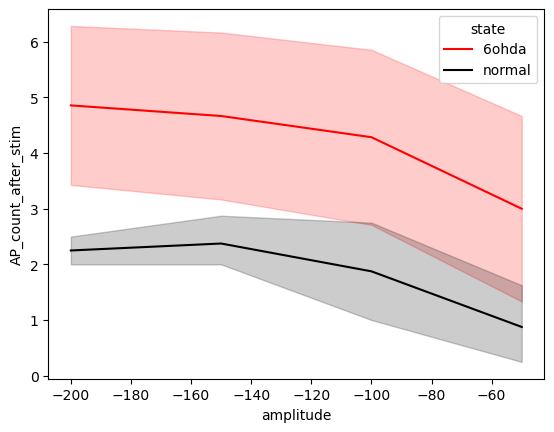

In [10]:
sns.lineplot(data=experiment_df[experiment_df['protocol'] == 'rmih'], x='amplitude', y='AP_count_after_stim', hue='state', palette=['red', 'black'])

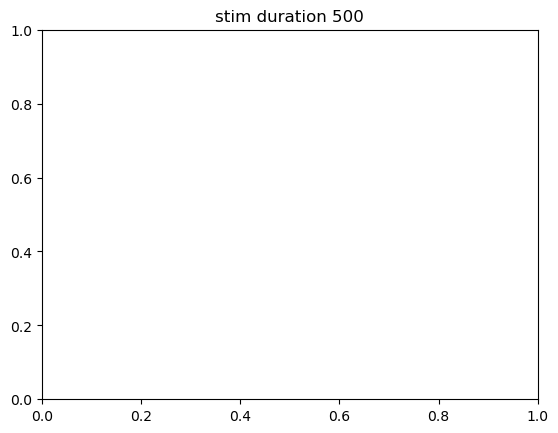

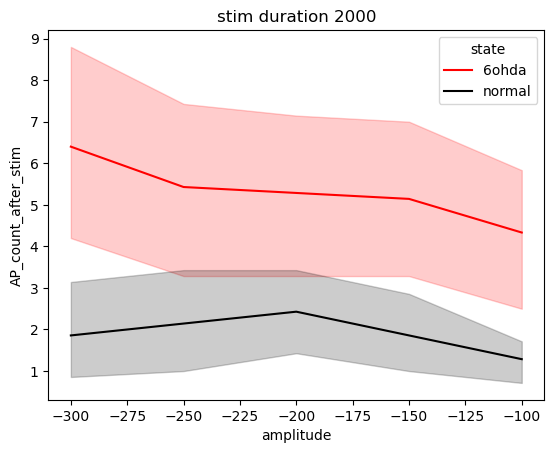

In [11]:
for dur in [500, 2000]:
    plt.title('stim duration ' + str(dur))
    sns.lineplot(data=experiment_df[(experiment_df['protocol'] == 'tburst') & (experiment_df['duration'] == dur)], x='amplitude', y='AP_count_after_stim', hue='state', palette=['red', 'black'])
    plt.show()

# Simulation data preparation

In [12]:
df = pd.read_csv('hof_3sd_0.csv')
df_no_km = pd.read_csv('hof_3sd_0_no_km.csv')

In [13]:
df.shape

(11655, 13)

In [14]:
df_no_km.shape

(11655, 13)

In [15]:
df.set_index(['etype', 'cellid', 'seed'], inplace=True)
df_no_km.set_index(['etype', 'cellid', 'seed'], inplace=True)

In [16]:
# remove neurons that fires spontaneously after KM blockade
df_no_km.drop(df_no_km[df_no_km['AP_count_before_stim'] > 0].index, inplace=True)

# select neurons
df = df.loc[df_no_km.index, :]

df.reset_index(inplace=True)
df_no_km.reset_index(inplace=True)

## Comparing curves for hyperpolarizing and depolarizing current steps

In [17]:
threshold = 3
    
y_variable = {'fi':'AP_count', 'tburst':'AP_count_after_stim', 'rmih':'AP_count_after_stim' }

for _state in df['state'].unique():
    for _protocol, _y_variable in y_variable.items():
        # estimate the experimental curves
        exp_curve = experiment_df[(experiment_df['state']==_state)&(experiment_df['protocol']==_protocol)]
        exp_curve = exp_curve.groupby(['amplitude', 'duration'])[_y_variable].describe()[['count', 'mean', 'std']]
        exp_curve.dropna(inplace=True)

        # go over the simulated curves
        for k, g in df[(df['state']==_state)&(df['protocol']==_protocol)].groupby(['cellid', 'seed']):
            sim_curve = g.groupby(['amplitude', 'duration'])[_y_variable].describe()[['count', 'mean', 'std']]
            sim_curve.dropna(inplace=True)
            
            # only cases shown in the experiments
            sim_curve = sim_curve.loc[exp_curve.index, :]

            # max abs z-score
            max_err = ((sim_curve['mean'] - exp_curve['mean']) / (exp_curve['std'] + 0.001)).abs().max()

            if max_err > threshold:
                # remove if exceeding the threshold
                k += (_state, )

                df.drop(df[(df[['cellid', 'seed', 'state']]==k).all(axis=1)].index, inplace=True)
                df_no_km.drop(df_no_km[(df_no_km[['cellid', 'seed', 'state']]==k).all(axis=1)].index, inplace=True)

In [18]:
df[['cellid', 'seed', 'state']].drop_duplicates()['state'].value_counts()

6ohda     157
normal     18
Name: state, dtype: int64

## Comparing curves for depolarizing current steps with and without $K_M$

In [19]:
alpha = 0.2 # p value threshold

for _state in df['state'].unique():

    # estimate the experimental curves
    exp_curve = experiment_df[(experiment_df['protocol']=='fi')&(experiment_df['state']==_state)]
    exp_curve = exp_curve.groupby(['amplitude', 'duration'])['AP_count'].describe()[['count', 'mean', 'std']]
    exp_curve.dropna(inplace=True)

    # go over the simulated curves
    for k, g in df[(df['protocol']=='fi')&(df['state']==_state)].groupby(['cellid', 'seed']):
        sim_curve = g.groupby(['amplitude', 'duration'])['AP_count'].describe()[['mean']]
        
        g_no_km = df_no_km.loc[(df_no_km[['cellid', 'seed', 'state', 'protocol']] == (k + (_state, 'fi'))).all(axis=1), :]
        sim_curve_no_km = g_no_km.groupby(['amplitude', 'duration'])['AP_count'].describe()[['mean']]
        
        # compare normal vs xe991 curves
        p = stats.ranksums(sim_curve.to_numpy()[:, 0], sim_curve_no_km.to_numpy()[:, 0] )[1]        

        if  (_state == 'normal' and p >= alpha) or (_state == '6ohda' and p < alpha):
            k += (_state, )
            df.drop(df[(df[['cellid', 'seed', 'state']] == k).all(axis=1)].index, inplace=True)
            df_no_km.drop(df_no_km[(df_no_km[['cellid', 'seed', 'state']] == k).all(axis=1)].index, inplace=True)

In [20]:
df[['cellid', 'seed', 'state']].drop_duplicates()['state'].value_counts()

normal    18
6ohda     16
Name: state, dtype: int64

# Save models to files

In [21]:
def filter_models(filename, id_list, fileout=None):
    good_models = {}
    for k, v in np.load(filename, allow_pickle=True).tolist().items():
       if k in id_list: 
         good_models.update({k:v})
        
    if fileout:
        np.save(fileout, good_models, allow_pickle=True)

In [22]:
filter_models("hof_3sd_0.npy", \
              df[['etype', 'cellid', 'seed']].drop_duplicates().set_index(['etype', 'cellid', 'seed']).index.tolist(), \
              fileout="hof_3sd_0_good.npy")